In [1]:
# 下準備
import os
import sys
import random

import numpy as np
from tqdm.notebook import tqdm

# 実験に使うデータ数
n_samples = 2000

# シードの固定
random.seed(31415)
np.random.seed(31415)

In [2]:
import requests

url = "http://lab.ndl.go.jp/dataset/hiragana73.zip"
filename = os.path.basename(url)

# データ格納用のディレクトリを作る
os.makedirs("data", exist_ok=True)

# HTTPリクエストを送ってデータサイズを取得
r = requests.get(url, stream=True)
total_size = int(r.headers.get("content-length", 0))
chunk_size = 65535

# 実際のファイルのダウンロード
pbar = tqdm(total=total_size, unit="B", unit_scale=True)
with open(filename, "wb") as f:
    for data in r.iter_content(chunk_size):
        f.write(data)
        pbar.update(chunk_size)

  0%|          | 0.00/233M [00:00<?, ?B/s]

In [3]:
# ダウンロードが完了したらZIPを展開する
import zipfile

with zipfile.ZipFile(filename, "r") as f:
    f.extractall()

In [4]:
a = "あ"
hira_a = hex(ord(a))
print(hira_a)

0x3042


In [5]:
for i in range(82):
    print(chr(int(hira_a, 16) + i), end="")

あぃいぅうぇえぉおかがきぎくぐけげこごさざしじすずせぜそぞただちぢっつづてでとどなにぬねのはばぱひびぴふぶぷへべぺほぼぽまみむめもゃやゅゆょよらりるれろゎわゐゑをん

In [6]:
# サブフォルダの数を調べる
dirname = "hiragana73"
folders = sorted([d for d in os.listdir(dirname)])
print('There are {:d} folders in "{:s}".'.format(len(folders), dirname))

# フォルダに対応する文字を列挙
for d in folders:
    x = d.replace("U", "0x")
    print(chr(int(x, 16)), end="")

There are 73 folders in "hiragana73".
あいうえおかがきぎくぐけげこごさざしじすずせぜそぞただちぢつづてでとどなにぬねのはばぱひびぴふぶぷへべぺほぼぽまみむめもやゆよらりるれろわゐゑをん

In [7]:
import numpy as np
import pandas as pd
from IPython import display

chars = [chr(int(d.replace("U", "0x"), 16)) for d in folders]
dir_paths = [os.path.join(dirname, d) for d in folders]
num_images = [len(os.listdir(d)) for d in dir_paths]

df = pd.DataFrame([(c, n) for c, n in zip(chars, num_images)])
sub_dfs = [df[i : i + 10].reset_index(drop=True) for i in range(0, len(df.index), 10)]
df = pd.concat(sub_dfs, axis=1).fillna("")

df.index = [i for i in range(len(df.index))]
df.columns = [j for j in range(len(df.columns))]


def custom_style(df):
    index = df.index
    columns = df.columns
    styles = []
    for i in range(len(index)):
        s = []
        for j in range(len(columns)):
            if columns[j] % 2 == 0:
                s.append("font-weight: bold;")
            else:
                s.append(None)
        styles.append(s)

    return np.array(styles, dtype="object")


df.style.format(precision=0).format_index("", axis=1).format_index("", axis=0).apply(
    custom_style, axis=None
)

,,,,,,,,,,,,,,,,
,あ,1208,ぐ,1043,ず,1046,づ,1080,は,1247,べ,1109,や,1285,ゑ,1030
,い,1122,け,1155,せ,1165,て,1213,ば,1105,ぺ,268,ゆ,1282,を,1254
,う,1148,げ,1058,ぜ,1115,で,1178,ぱ,262,ほ,1115,よ,1166,ん,1285
,え,1077,こ,1115,そ,1285,と,1184,ひ,1074,ぼ,1044,ら,1114,,
,お,1283,ご,1078,ぞ,1066,ど,1134,び,1045,ぽ,261,り,1244,,
,か,1259,さ,1261,た,1285,な,1233,ぴ,126,ま,1285,る,1190,,
,が,1200,ざ,1070,だ,1116,に,1260,ふ,1285,み,1142,れ,1238,,
,き,1121,し,1285,ち,1052,ぬ,1093,ぶ,1149,む,1058,ろ,1069,,
,ぎ,1091,じ,1099,ぢ,1132,ね,1126,ぷ,112,め,1233,わ,1283,,
,く,1266,す,1282,つ,1142,の,1160,へ,1114,も,1187,ゐ,1053,,


In [8]:
# 文字への整数の割り当て
n_chars = len(chars)
char2num = {c: i for i, c in enumerate(chars)}

In [9]:
import cv2

n_total = sum(num_images)
pbar = tqdm(total=n_total)

# 画像の読み取り
X = []  # 画像データ
y = []  # ラベルデータ
for d in dir_paths:
    # 文字に対する数字を計算
    char = os.path.basename(d).replace("U", "0x")
    char = chr(int(char, 16))
    num = char2num[char]
    # 画像の読み込み
    image_files = [os.path.join(d, f) for f in os.listdir(d)]
    image_files = [f for f in image_files if f.endswith(".png")]
    for f in image_files:
        image = cv2.imread(f, cv2.IMREAD_COLOR)
        if image is None:
            raise IOError("Failed to load image: {:s}".format(f))

        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # データのランダム回転、ランダムスケール
        height, width = image.shape
        center = (width // 2, height // 2)
        scale = np.random.uniform(0.8, 1.1)
        angle = np.random.uniform(-90, 90)
        trans = cv2.getRotationMatrix2D(center, angle, scale)
        image = cv2.warpAffine(image, trans, (width, height), borderMode=cv2.BORDER_REPLICATE)
        image = cv2.bilateralFilter(image, -1, 15.0, 5.0)

        X.append(image.flatten())
        y.append(num)

        pbar.update(1)

  0%|          | 0/80000 [00:00<?, ?it/s]

In [10]:
from sklearn import model_selection

X, X_test, y, y_test = model_selection.train_test_split(
    X, y, train_size=70000, test_size=10000, shuffle=True
)

X, X_val, y, y_val = model_selection.train_test_split(
    X, y, train_size=60000, test_size=10000, shuffle=True
)

X, y = X[:n_samples], y[:n_samples]
X_val, y_val = X_val[:n_samples], y_val[:n_samples]
X_test, y_test = X_test[:n_samples], y_test[:n_samples]

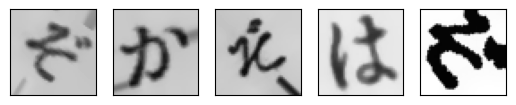

In [11]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 5)
for i in range(5):
    axs[i].imshow(X[i].reshape((48, 48)), cmap="gray", vmin=0, vmax=255, interpolation=None)
    axs[i].set_xticks([])
    axs[i].set_yticks([])
plt.show()

In [12]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

svc_params = {
    "kernel": "poly",
    "tol": 1.0e-3,
    "max_iter": -1,
}

clf = make_pipeline(
    StandardScaler(),
    SVC(**svc_params),
)

clf.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(kernel='poly'))])

In [13]:
# 訓練時の識別精度の確認
y_pred = clf.predict(X)
acc_train = 100.0 * np.sum(y_pred == y) / len(y)
print("Naive: acc(train)={:.2f}%".format(acc_train))

Naive: acc(train)=41.50%


In [14]:
# テストデータに対する識別精度の計算
y_pred = clf.predict(X_test)
acc_test = 100.0 * np.sum(y_pred == y_test) / len(y_test)
print("Naive: acc(test)={:.2f}%".format(acc_test))

Naive: acc(test)=7.55%


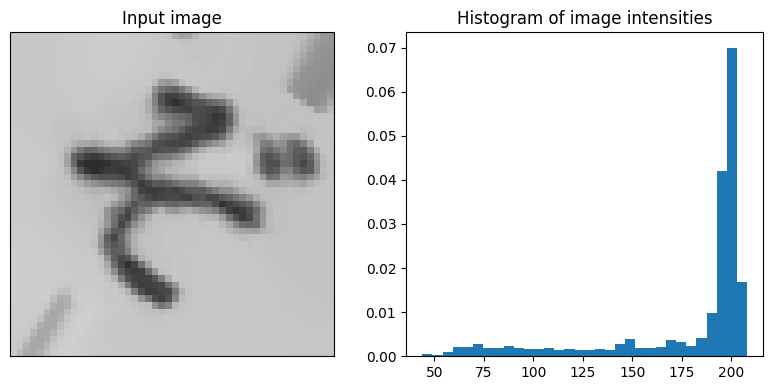

In [15]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

im = X[0].reshape((48, 48))

fig = plt.figure(figsize=(8, 4))
gs = GridSpec(1, 2, width_ratios=[1, 1], figure=fig)

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

ax1.imshow(im, cmap="gray", vmin=0, vmax=255, interpolation=None)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title("Input image")

ax2.hist(im.flatten(), bins=32, density=True)
ax2.set_title("Histogram of image intensities")

plt.tight_layout()
plt.show()

In [16]:
H = []
for x in tqdm(X):
    h = np.histogram(x, bins=255, density=True)
    H.append(h[0])

  0%|          | 0/2000 [00:00<?, ?it/s]

In [17]:
clf2 = make_pipeline(
    StandardScaler(),
    SVC(**svc_params),
)
clf2.fit(H, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(kernel='poly'))])

In [18]:
# 訓練時の識別精度の確認
y_pred = clf2.predict(H)
acc_train = 100.0 * np.sum(y_pred == y) / len(y)
print("Histogram: acc(train)={:.2f}%".format(acc_train))

Histogram: acc(train)=29.20%


In [19]:
H_test = []
for x in tqdm(X_test):
    h = np.histogram(x, bins=255, density=True)
    H_test.append(h[0])

  0%|          | 0/2000 [00:00<?, ?it/s]

In [20]:
# テストデータに対する識別精度の計算
y_pred = clf2.predict(H_test)
acc_test = 100.0 * np.sum(y_pred == y_test) / len(y_test)
print("Histogram: acc(test)={:.2f}%".format(acc_test))

Histogram: acc(test)=1.50%


In [21]:
def draw_frame(problem, fig, ax):
    mask = (problem == 0).astype("float32")
    frame = []
    ax.set_xticks(np.arange(0, 9))
    ax.set_yticks(np.arange(0, 9))
    ax.set_xticklabels(np.arange(1, 10))
    ax.set_yticklabels(np.arange(1, 10))

    ax.set_xticks(np.arange(1, 10) - 0.5, minor=True)
    ax.set_yticks(np.arange(1, 10) - 0.5, minor=True)
    ax.set_xticks(np.arange(3, 10, 3) - 0.5)
    ax.set_yticks(np.arange(3, 10, 3) - 0.5)

    ims = plt.imshow(mask * 0.2, cmap="Blues", vmin=0.0, vmax=1.0)
    frame.append(ims)
    for (i, j), z in np.ndenumerate(problem):
        txt = ax.text(j, i, "{:d}".format(z), ha="center", va="center", color="k", fontsize=15)
        frame.append(txt)

    ax.grid(which="minor", color="k", linestyle="-", linewidth=0.5)
    ax.grid(which="major", color="k", linestyle="-", linewidth=1.0)

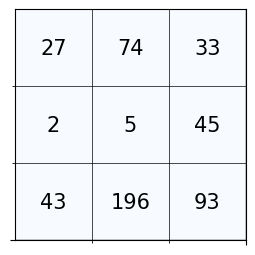

In [22]:
m = np.random.randint(0, 256, size=(3, 3))
fig, ax = plt.subplots(figsize=(3, 3))
draw_frame(m, fig, ax)

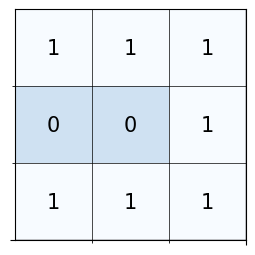

In [23]:
c = m[1, 1]
b = (m > c).astype("int32")
fig, ax = plt.subplots(figsize=(3, 3))
draw_frame(b, fig, ax)

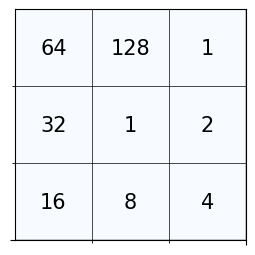

In [24]:
p = 2 ** np.array([[6, 7, 0], [5, 0, 1], [4, 3, 2]])

fig, ax = plt.subplots(figsize=(3, 3))
draw_frame(p, fig, ax)

In [25]:
from IPython.display import Markdown

Markdown(f"すると、上記の3x3の領域に対しては、LBPの値として**{np.sum(b * p):d}**が求まる")

すると、上記の3x3の領域に対しては、LBPの値として**223**が求まる

In [26]:
lbp = np.sum(b * p)
print("LBP={:d}".format(lbp))

LBP=223


In [27]:
im = X[0].reshape((48, 48))

lbp = np.zeros_like(im).astype("uint8")
for j in range(1, im.shape[0] - 1):
    for i in range(1, im.shape[1] - 1):
        c = im[i, j]
        m = im[i - 1 : i + 2, j - 1 : j + 2]
        b = (m > c).astype("int32")
        lbp[i, j] = np.sum(p * b)

# 輪郭の画素では計算できないので、輪郭を除いておく
lbp = lbp[1:-1, 1:-1]

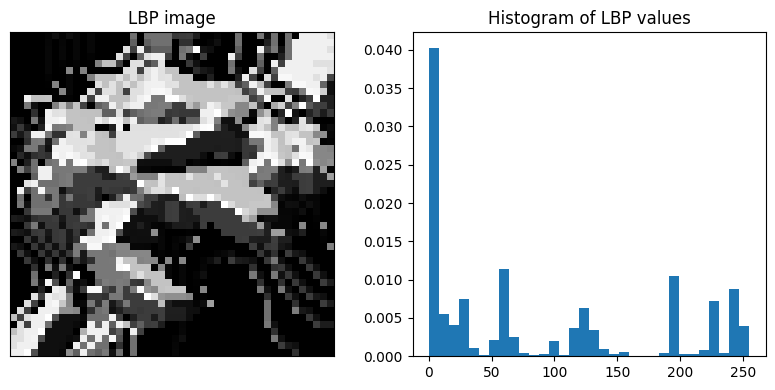

In [28]:
fig = plt.figure(figsize=(8, 4))
gs = GridSpec(1, 2, width_ratios=[1, 1], figure=fig)

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

ax1.imshow(lbp, cmap="gray", vmin=0, vmax=255, interpolation=None)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title("LBP image")

ax2.hist(lbp.flatten(), bins=32, density=True)
ax2.set_title("Histogram of LBP values")

plt.tight_layout()
plt.show()

In [29]:
from sklearn.feature_extraction.image import extract_patches_2d


def calc_lbp(x):
    pat = (2 ** np.array([[0, 1, 2], [7, 0, 3], [6, 5, 4]])).astype("int32")

    patches = extract_patches_2d(x, (3, 3))
    centers = patches[:, 1, 1].reshape((-1, 1, 1))
    binary = (patches > centers).astype("int32")

    return np.sum(binary * pat.reshape((1, 3, 3)), axis=(1, 2))


def calc_lbp_hist(x):
    lbp = calc_lbp(x)
    return np.histogram(lbp, bins=255, density=True)[0]


L = [calc_lbp_hist(x.reshape((48, 48))) for x in tqdm(X)]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [30]:
clf3 = make_pipeline(
    StandardScaler(),
    SVC(**svc_params),
)
clf3.fit(L, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(kernel='poly'))])

In [31]:
# 訓練時の識別精度の確認
y_pred = clf3.predict(L)
acc_train = 100.0 * np.sum(y_pred == y) / len(y)
print("LBP: acc(train)={:.2f}%".format(acc_train))

LBP: acc(train)=38.65%


In [32]:
L_test = [calc_lbp_hist(x.reshape((48, 48))) for x in tqdm(X_test)]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [33]:
# テストデータに対する識別精度の計算
y_pred = clf3.predict(L_test)
acc_test = 100.0 * np.sum(y_pred == y_test) / len(y_test)
print("LBP: acc(test)={:.2f}%".format(acc_test))

LBP: acc(test)=1.60%


In [34]:
from skimage.feature import local_binary_pattern

n_angles = 36
lbp = local_binary_pattern(X[0].reshape((48, 48)), n_angles, 1.0, method="uniform")

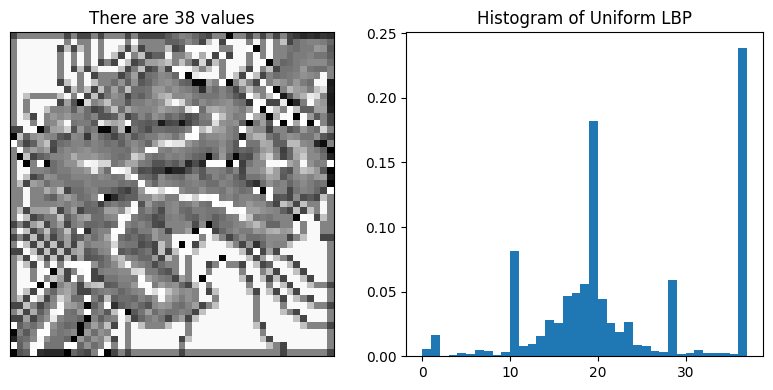

In [35]:
fig = plt.figure(figsize=(8, 4))
gs = GridSpec(1, 2, width_ratios=[1, 1], figure=fig)

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

ax1.imshow(lbp, cmap="gray", interpolation=None)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title("There are {:d} values".format(int(np.max(lbp)) + 1))

ax2.hist(lbp.flatten(), bins=n_angles + 1, density=True)
ax2.set_title("Histogram of Uniform LBP")

plt.tight_layout()
plt.show()

In [36]:
def calc_ulbp_hist(x):
    lbp = local_binary_pattern(x, n_angles, 1.0, method="uniform")
    return np.histogram(lbp, bins=n_angles + 1, density=True)[0]


L = [calc_ulbp_hist(x.reshape((48, 48))) for x in tqdm(X)]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [37]:
clf4 = make_pipeline(
    StandardScaler(),
    SVC(**svc_params),
)
clf4.fit(L, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(kernel='poly'))])

In [38]:
# 訓練時の識別精度の確認
y_pred = clf4.predict(L)
acc_train = 100.0 * np.sum(y_pred == y) / len(y)
print("Uniform LBP: acc(train)={:.2f}%".format(acc_train))

Uniform LBP: acc(train)=24.15%


In [39]:
L_test = [calc_ulbp_hist(x.reshape((48, 48))) for x in tqdm(X_test)]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [40]:
# テストデータに対する識別精度の計算
y_pred = clf4.predict(L_test)
acc_test = 100.0 * np.sum(y_pred == y_test) / len(y_test)
print("Uniform LBP: acc(test)={:.2f}%".format(acc_test))

Uniform LBP: acc(test)=3.55%


In [41]:
im = X[0].reshape((48, 48))
s = 8
patches = [im[y : y + 8, x : x + 8] for y in range(0, 48, s) for x in range(0, 48, s)]

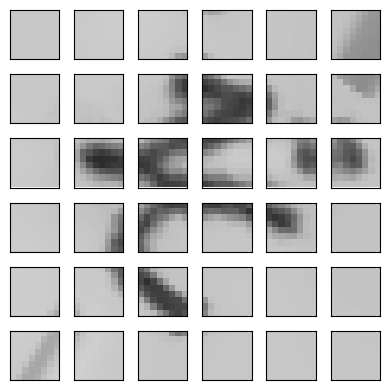

In [42]:
fig = plt.figure(figsize=(4, 4))
gs = GridSpec(6, 6, figure=fig)

for i in range(6):
    for j in range(6):
        ax = plt.subplot(gs[i, j])
        ax.imshow(patches[i * 6 + j], cmap="gray", vmin=0, vmax=255, interpolation=None)
        ax.set_xticks([])
        ax.set_yticks([])

plt.tight_layout()
plt.show()

In [43]:
def calc_hist(p, n_angles=9):
    dx = cv2.Sobel(p, cv2.CV_8U, 1, 0)
    dy = cv2.Sobel(p, cv2.CV_8U, 0, 1)
    dx, dy = dx.astype("float32"), dy.astype("float32")

    g = np.sqrt(dx * dx + dy * dy)
    theta = 180.0 * np.arctan(np.abs(dy), dx) / np.pi
    t = (theta * n_angles / 180.0).astype("int32")

    h = np.zeros((n_angles), dtype="float32")
    for g_, t_ in zip(g.flatten(), t.flatten()):
        h[t_] += g_

    return h


n_angles = 9
hists = np.array([calc_hist(p, n_angles) for p in patches])
print(f"{hists.shape[0]:d} histograms with {hists.shape[1]:d} bins are obtained!")

36 histograms with 9 bins are obtained!


In [44]:
bs = 3
hists = hists.reshape((6, 6, -1))

# ブロックの取り出し
blocks = np.array(
    [hists[i : i + bs, j : j + bs] for i in range(6 - bs + 1) for j in range(6 - bs + 1)]
)
hog = blocks.reshape((-1, n_angles * bs * bs))

# ブロックごとのヒストグラムのノルムが1となるように正規化
hog = hog / np.sqrt(np.sum(hog * hog, axis=1, keepdims=True))
hog = hog.flatten()

In [45]:
def calc_hog(im):
    h, w = im.shape
    s = 8
    bs = 3
    n_angles = 9

    ph = h // s
    pw = w // s

    patches = [im[y : y + 8, x : x + 8] for y in range(0, h, s) for x in range(0, w, s)]
    hists = np.array([calc_hist(p, n_angles) for p in patches])
    hists = hists.reshape((ph, pw, -1))

    blocks = np.array(
        [hists[i : i + bs, j : j + bs] for i in range(ph - bs + 1) for j in range(pw - bs + 1)]
    )
    hog = blocks.reshape((-1, n_angles * bs * bs))

    hog = hog / (np.sqrt(np.sum(hog * hog, axis=1, keepdims=True)) + 1.0e-8)

    hog = hog.flatten()

    return hog

In [46]:
hogs = [calc_hog(x.reshape((48, 48))) for x in tqdm(X)]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [47]:
clf5 = make_pipeline(
    StandardScaler(),
    SVC(**svc_params),
)
clf5.fit(hogs, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(kernel='poly'))])

In [48]:
# 訓練時の識別精度の確認
y_pred = clf5.predict(hogs)
acc_train = 100.0 * np.sum(y_pred == y) / len(y)
print("HOG: acc(train)={:.2f}%".format(acc_train))

HOG: acc(train)=33.55%


In [49]:
hogs_test = [calc_hog(x.reshape((48, 48))) for x in tqdm(X_test)]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [50]:
# テストデータに対する識別精度の計算
y_pred = clf5.predict(hogs_test)
acc_test = 100.0 * np.sum(y_pred == y_test) / len(y_test)
print("Uniform LBP: acc(test)={:.2f}%".format(acc_test))

Uniform LBP: acc(test)=4.90%


In [51]:
sift = cv2.SIFT_create()
im = X[0].reshape((48, 48)).copy()
im = cv2.resize(im, (256, 256))

# 特徴点の検出
keypoints = sift.detect(im)

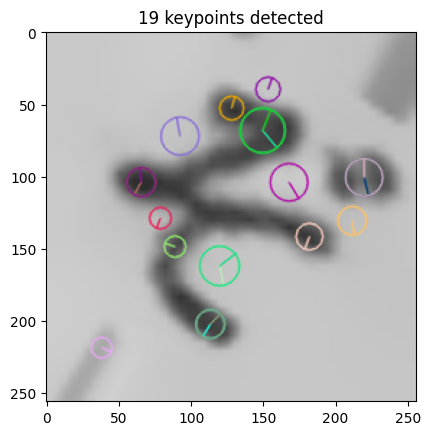

In [52]:
im_sift = cv2.drawKeypoints(
    im,
    keypoints,
    None,
    flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS,
)

plt.imshow(im_sift)
plt.title("{:d} keypoints detected".format(len(keypoints)))
plt.show()

In [53]:
# 特徴量の計算
_, descriptors = sift.compute(im, keypoints)
print(f"{descriptors.shape[0]:d} descriptors with {descriptors.shape[1]:d} dimensions are detected!!")

19 descriptors with 128 dimensions are detected!!
